In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
from sort_src.flow import FlowData
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sort_src.pydscatter import dscatter_plot
from sort_src.sort import SORT

## Figure 1b

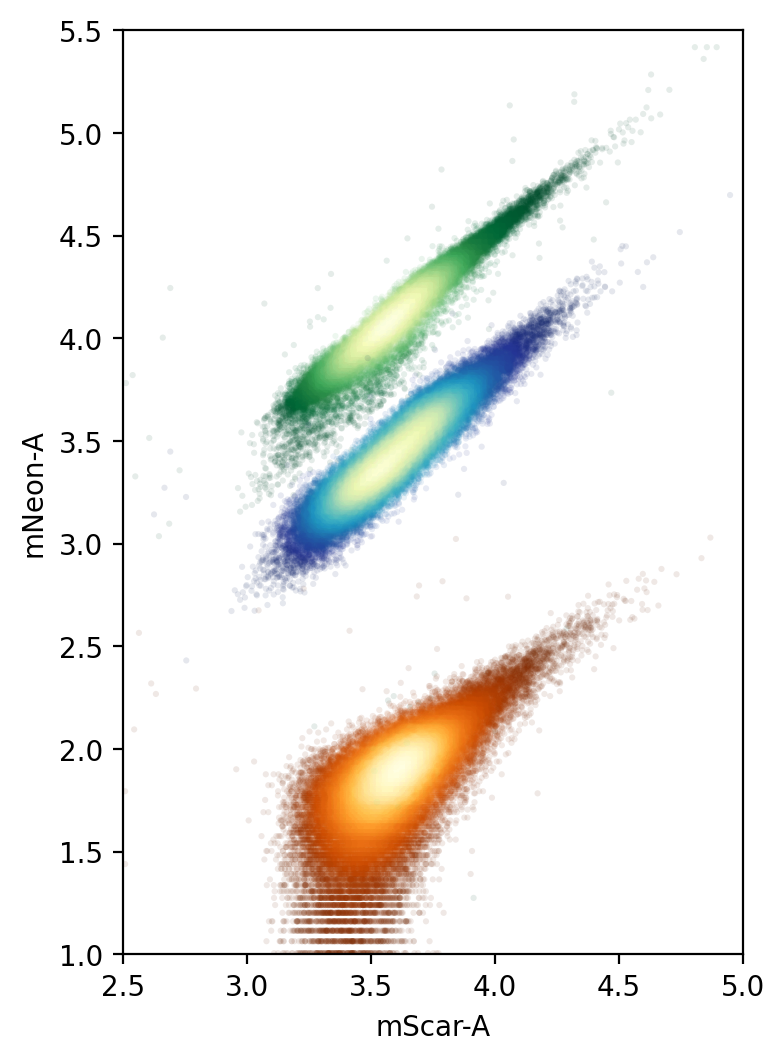

In [3]:
path = '../data/fcs_single/'

plt.figure(figsize=[4, 6])
neg = FlowData(path + 'neg_1.fcs', 'neg')
pos = FlowData(path + 'pos_1.fcs', 'pos')
rps = FlowData(path + 'act1' + '_1.fcs', 'act1')
dscatter_plot(np.log10(pos.data['PE-A']), np.log10(pos.data['FITC-A']), lamb=50, alpha=0.1, cmap='YlGn_r', edgecolors='none', rasterized=True)
dscatter_plot(np.log10(neg.data['PE-A']), np.log10(neg.data['FITC-A']), lamb=50, alpha=0.1, cmap='YlOrBr_r', edgecolors='none', rasterized=True)
dscatter_plot(np.log10(rps.data['PE-A']), np.log10(rps.data['FITC-A']), lamb=50, alpha=0.1, cmap='YlGnBu_r', edgecolors='none', rasterized=True)
plt.xlabel('mScar-A')
plt.ylabel('mNeon-A')

plt.xlim([2.5, 5])
plt.ylim([1, 5.5])
plt.show()

## Figure 1c

In [4]:
def load_ctrl(fcs):
    dum = FlowData(fcs, '???')
    dum.est_params()
    return(dum.mean)

def get_values(fcs, pos, neg, bins):
    dum = FlowData(fcs, '???', norm=[neg, pos])
    x, y = dum.get_hist_ratio(norm=True, use_gate=False, bins=bins)
    return(x, y)

100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


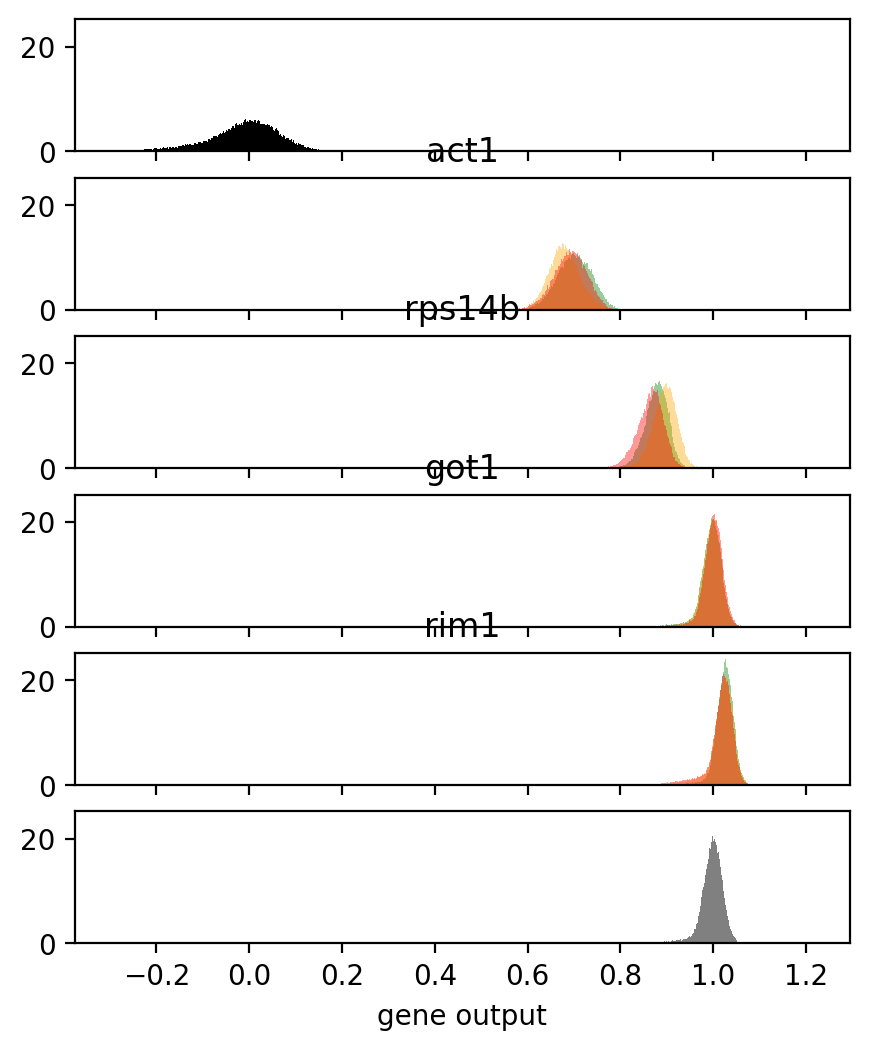

In [5]:
path = '../data/fcs_single/'
introns = ['act1', 'rps14b', 'got1', 'rim1']

# controls
neg1 = load_ctrl(path + 'neg_1.fcs')
neg2 = load_ctrl(path + 'neg_2.fcs')
neg3 = load_ctrl(path + 'neg_3.fcs')

pos1 = load_ctrl(path + 'pos_1.fcs')
pos2 = load_ctrl(path + 'pos_2.fcs')
pos3 = load_ctrl(path + 'pos_3.fcs')

width = 0.002
bins = np.arange(-0.3, 1.22, width)

fig, axs = plt.subplots(len(introns)+2, 1, figsize=[5, 6], sharex=True, sharey=True)

for i, intron in tqdm(enumerate(introns), total=len(introns)):
    x, y1 = get_values(path + intron + '_1.fcs', pos1, neg1, bins)
    _, y2 = get_values(path + intron + '_2.fcs', pos2, neg2, bins)
    _, y3 = get_values(path + intron + '_3.fcs', pos3, neg3, bins)

    axs[i+1].bar(x, y1, width, color='green', alpha=0.4)
    axs[i+1].bar(x, y2, width, color='orange', alpha=0.4)
    axs[i+1].bar(x, y3, width, color='red', alpha=0.4)

    axs[i+1].set_title(intron)

_, y_neg = get_values(path + 'neg_1.fcs', pos1, neg1, bins)
_, y_pos = get_values(path + 'pos_1.fcs', pos1, neg1, bins)
axs[ 0].bar(x, y_neg, width, color='black', alpha=1)
axs[-1].bar(x, y_pos, width, color='gray', alpha=1)
axs[-1].set_xlabel('gene output')

plt.show()

## Figure 1e

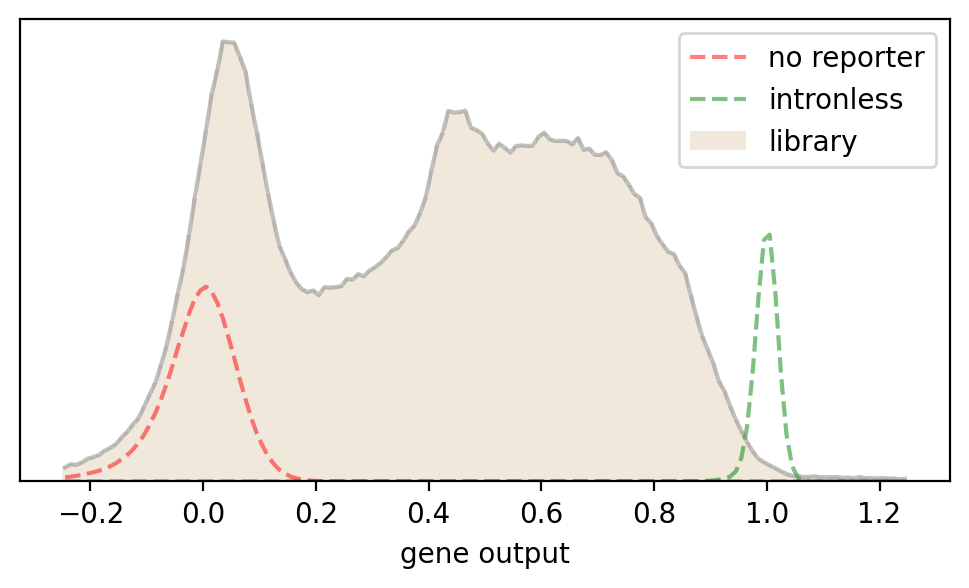

In [6]:
# Plot gene output distribution for random library

# load controls to calculate normalization factors
dum = FlowData('../data/fcs/random/random_wt_neg_1.fcs', 'neg')
dum.est_params()
low_y = dum.mean
dum = FlowData('../data/fcs/random/random_wt_pos_1.fcs', 'pos')
dum.est_params()
hig_y = dum.mean
norm = [low_y, hig_y]

# load data and normalize
neg = FlowData('../data/fcs/random/random_wt_neg_1.fcs', 'neg', norm=norm)
pos = FlowData('../data/fcs/random/random_wt_pos_1.fcs', 'pos', norm=norm)
lib_B = FlowData('../data/fcs/random/random_lib_1.fcs', 'lib', norm=norm)

# bin distributions
bin_size = 0.01
bins = np.arange(-0.25, 1.25+bin_size, bin_size)

binned_neg, _ = np.histogram(neg.rat_norm, bins=bins, density=True)
binned_pos, _ = np.histogram(pos.rat_norm, bins=bins, density=True)
binned_lib_B, _ = np.histogram(lib_B.rat_norm, bins=bins, density=True)

# draw figure – distributions are somewhat arbitrarily scaled to make them match in height
fig, axs = plt.subplots(figsize=[6,3])
axs.plot(bins[:-1]+0.5*bin_size, binned_neg*0.7, '--', color='red', alpha=0.5, label='no reporter')
axs.plot(bins[:-1]+0.5*bin_size, binned_pos*0.3, '--', color='green', alpha=0.5, label='intronless')
axs.bar(bins[:-1]+0.5*bin_size, binned_lib_B*7, bin_size, color='tan', alpha=0.3, label="library")
axs.plot(bins[:-1]+0.5*bin_size, binned_lib_B*7, color='gray', alpha=0.5)
axs.set_xlabel('gene output')
axs.set_yticks([])
axs.set_yticklabels([])

plt.legend()
plt.show()

## Figure 1f

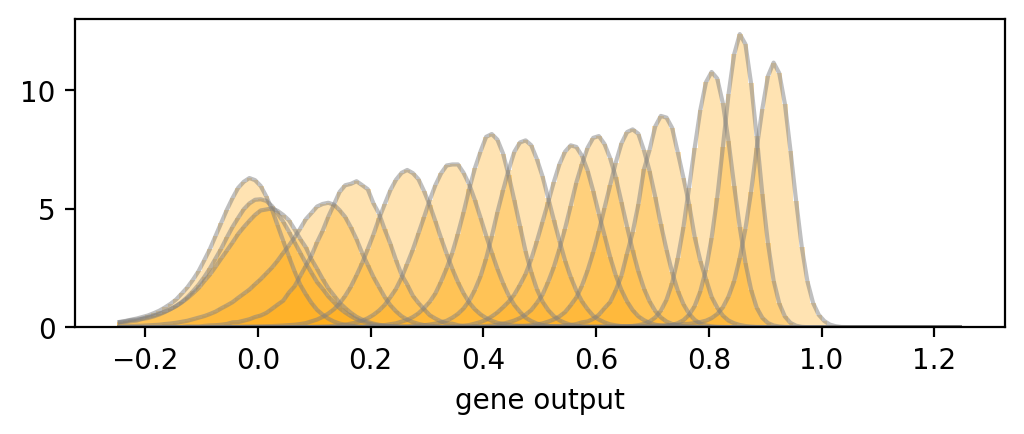

In [7]:
# plot gene output distributions of Sort-seq bins for the random library

# load Sort-seq element from configuration csv specifying all file paths
ran = SORT('../config/sortseq_csvs/random.csv', '../config/fasta_files/random_lib_clust.fasta')
ran.load_flow_data(plot=False)

# in this case, adding additional Sort-seq bins that were sorted separately (needed because they have different control measurements)
ran.add_sort_data('../data/fcs/random/random_bin15.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin15_counts.pkl', 
                  'bin_15')

ran.add_sort_data('../data/fcs/random/random_bin16.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin16_counts.pkl', 
                  'bin_16')

# draw figure
fig, axs = plt.subplots(figsize=[6, 2])
ran.plot_hists(axs)
plt.xlabel('gene output')
plt.show()